In [11]:
from csrl.mdp import GridMDP
from csrl.oa import OmegaAutomaton
from csrl import ControlSynthesis
import numpy as np 
import matplotlib.pyplot as plt
from tqdm import tqdm
# import scipy.special as sc
from scipy.special import softmax

using dill to import product MDP generated offline, avoiding installation of rabinzer4 package

In [12]:
import dill
# dill.load_session('product_MDP.pkl')
dill.load_session('product_MDP_2_Gammma_0.9_0.99.pkl')
csrl.discount

0.99

In [13]:
def softmax_state(theta,state,csrl):
    Action_set = csrl.A[state]  
    # temp = theta[state][:len(Action_set)] / np.linalg.norm(theta[state][:len(Action_set)])
    temp = theta[state][:len(Action_set)]
    Policy_A_theta = softmax(temp)
    # Policy_A_theta = np.exp(temp) / np.sum(np.exp(temp))
    return Policy_A_theta

def derivate_softmax(theta,state,csrl,action,Policy_A_theta):
    Action_set = csrl.A[state]
    P_a = Policy_A_theta[Action_set.index(action)]
    Grad_Pi = np.zeros([len(Action_set),1])
    for i in range(len(Grad_Pi)):
        if i == Action_set.index(action):
            Grad_Pi[i] = P_a*(1-P_a)
        else:
            Grad_Pi[i] = -P_a * Policy_A_theta[i]
    return Grad_Pi

def one_trajectroy(initial_state,csrl,theta,length): 
    state   = initial_state
    reward  = csrl.reward[state]
    state_hist  = [state]
    reward_hist = [reward]
    gamma_hist  = [csrl.discountB if reward else csrl.discount]
    action_hist = []
    for t in range(length):
        A_set = csrl.A[state]
        # softmax, from theta to probability
        # Policy, action distributation given state and theta
        action = A_set[np.random.choice(len(A_set),p= softmax_state(theta,state,csrl) )]
        states, probs = csrl.transition_probs[state][action]
        state = states[np.random.choice(len(states),p=probs)]
        reward = csrl.reward[state]
        gamma = csrl.discountB if reward else csrl.discount
        state_hist.append(state)
        reward_hist.append(reward)
        gamma_hist.append(gamma)
        action_hist.append(action)
    state_hist  = state_hist[:-1]
    reward_hist = reward_hist[:-1]
    gamma_hist  = gamma_hist[:-1]
    G_t = reward_hist[-1]
    G_t_hist = [G_t]
    for t in range(length-2,-1,-1):
        G_t = reward_hist[t] + gamma_hist[t] * G_t
        G_t_hist.append(G_t)
    G_t_hist.reverse()
    return state_hist, action_hist, G_t_hist, gamma_hist

this derivate_softmax is $\frac{\partial \pi(a_t|s)}{\partial \theta} $

In [15]:
#%%
T = 100
K = 10000
print(csrl.discount)
print(csrl.discountB)
print(csrl.reward)

0.99
0.9
[[[[0.  0.  0.  0. ]
   [0.  0.  0.  0. ]
   [0.  0.  0.  0. ]
   [0.  0.  0.  0. ]
   [0.  0.  0.  0. ]]

  [[0.  0.  0.  0. ]
   [0.  0.  0.1 0. ]
   [0.  0.  0.  0. ]
   [0.  0.  0.1 0. ]
   [0.  0.  0.  0. ]]

  [[0.  0.  0.  0. ]
   [0.  0.  0.  0.1]
   [0.  0.  0.  0. ]
   [0.1 0.  0.  0. ]
   [0.  0.  0.  0. ]]

  [[0.  0.  0.  0. ]
   [0.  0.  0.  0. ]
   [0.  0.  0.  0. ]
   [0.  0.  0.  0. ]
   [0.  0.  0.  0. ]]]]


$T$ batch size, $K$ steps, set $\gamma<\gamma_B$

In [16]:
theta = np.ones(csrl.shape)
theta_hist = np.zeros( [K+1] + list(csrl.shape) )
theta_hist[0] = theta
theta_hist = np.zeros( [K+1] + list(csrl.shape) )
V = np.zeros(csrl.shape[:-1])
V_hist = np.zeros([K+1] + list(csrl.shape[:-1]) )

for k in tqdm(range(K)):
    # k_th episode
# =============================================================================SSSSSSSS
# simulate and record a trajectroy,
    # initial state    
    state   = (csrl.shape[0]-1,csrl.oa.q0)+(csrl.mdp.random_state())  
    state_hist, action_hist, G_t_hist, gamma_hist = one_trajectroy(state,csrl,theta,T)
# =============================================================================
# use 1 trajectory to generate policy gradient and update parameter once, 
    # alpha = np.max((1.0*(1 - 1.5*k/K),0.001))
    n = 1
    alpha = np.min((1/n,0.05))

    for t3 in range(T):
        state   = state_hist[t3]
        action  = action_hist[t3]
        A_set   = csrl.A[state]
        # softmax, from theta to probability
        Policy_s = softmax_state(theta,state,csrl)
        P_a = Policy_s[A_set.index(action)]
        # derivate of log softmax, pi w.r.t. theta
        Grad_Pi = derivate_softmax(theta,state,csrl,action,Policy_s) / P_a
        
        PG = np.zeros(csrl.shape)
        Grad_V = np.zeros(csrl.shape[:-1])
        
        PG_state = np.prod(gamma_hist[0:t3:1])*(G_t_hist[t3]) * Grad_Pi 
        PG[state][0:len(PG_state):1] += PG_state.flatten()
        Grad_V[state] = G_t_hist[t3] - V[state]    
        
        theta = theta + alpha * PG
        V     = V     + alpha * Grad_V
        
        n = n + 1
        # PG_state = np.prod(gamma_hist[0:t3:1]) * (G_t_hist[t3] - V[state]) * Grad_Pi / P_a
        
    #     PG_state = np.prod(gamma_hist[0:t3:1]) * (G_t_hist[t3] + V[state_hist[-1]] - V[state]) * Grad_Pi 
    #     PG[state][0:len(PG_state):1] += PG_state.flatten()
    #     Grad_V[state] = Grad_V[state] + G_t_hist[t3] - V[state]       
    # theta = theta   + PG / T
    # V     = V       + Grad_V/T
    
    V_hist[k+1] = V
    theta_hist[k+1] = theta

100%|██████████| 10000/10000 [03:23<00:00, 49.07it/s]


choose a random initial state, generate 1 trajectory $\tau$, use this trajectory to update $\theta$ once,
$ \theta = \theta +  \mathbb{E}_\tau \big{[} \Gamma(0:t)[G_t + \hat{V}(s_T) - \hat{V}(s_t)]  \nabla_{\theta} \log (\pi_{\theta}(a_t|s_t)\big{]}$

In [18]:
#%% from theta to policy
policy = np.zeros(csrl.shape[:-1])
for i,q,r,c in csrl.states():
    state = (i,q,r,c)
    # temp = theta[state][0:len(csrl.A[state])]
    temp = theta[state][csrl.A[state]]
    policy[state] = csrl.A[state][np.argmax(temp)]
    policy = policy.astype(int)
print('policy')
print(policy[0,0])
print('value')
print( np.around( (np.sum(V_hist[round(k/10*9):k:1],axis=0)/(k/10))[0,0],decimals = 2 ))

policy
[[2 1 0 1]
 [2 2 2 5]
 [0 1 0 0]
 [5 3 3 3]
 [0 0 0 0]]
value
[[0.45 0.61 0.   0.8 ]
 [0.65 0.76 0.83 0.98]
 [0.   0.56 0.   0.81]
 [0.99 0.73 0.99 0.88]
 [0.84 0.   0.78 0.  ]]


use PR-averging, take avergae of a portition tail as result, 

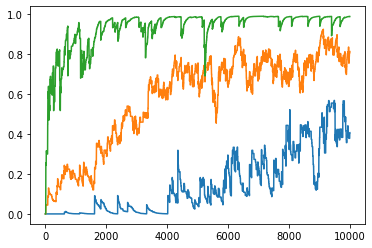

In [19]:
#%%
plt.figure()
# plt.hold(True)
plt.plot(range(k),V_hist[0:k:1,0,0,0,0])
plt.plot(range(k),V_hist[0:k:1,0,0,1,2])
plt.plot(range(k),V_hist[0:k:1,0,0,1,3])

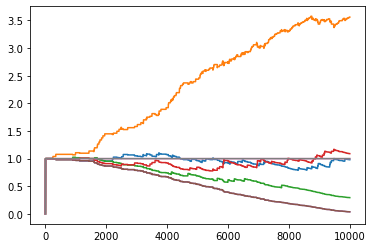

In [21]:
#%%
plt.figure()
plt.plot(range(k),theta_hist[0:k:1,0,0,2,1])

In [22]:
theta_hist[k,0,0,2,1]

array([0.98015481, 3.5599081 , 0.29454018, 1.08930836, 0.03804428,
       0.03804428, 1.        , 1.        ])

In [23]:
csrl.mdp.A

['U', 'D', 'R', 'L']